In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
from numpy import pi
import swarms
from random import randint, seed, uniform

from swarms import MMOON, MJUP, RJUP, AU, REARTH, MEARTH, PC, MSUN, LSUN, YEAR, MICRON, KM, SIG

In [2]:
def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def Mbol_to_L(M):
    return 10**(0.4*(4.74-M))

def distance_sampler(mean, std):
    s = 0
    while s <= 0:
        s = random.normal(loc=mean, scale=std)
    return s

def sample():
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.3 # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    
    return Dc, rho, eta, Q, g, Dt, Nstr, Dmax, fQ

In [3]:
def aoptChar(Lstar, Mstar, Tstar, Mtot, tage, Dt, Nstr, fQ, Dc, rho, eta):
    star = swarms.Star(Lstar, Mstar, Tstar, d=0)
    planet = swarms.Planet(star, M=318*MEARTH , R=None, a=0, Q=Q, Z='002', age=age)
    a_opt = aopt11(star, Mtot, tage, planet, Dt, Nstr, fQ, Dc, rho, eta, charFactor=1., f_vrel=4./pi)
    return a_opt

In [4]:
def aoptChar2(Lstar, Mstar, Tstar, Mtot, tage, Dt, Nstr, fQ, Dc, rho, eta, lamb):
    star = swarms.Star(Lstar, Mstar, Tstar, d=0)
    planet = swarms.Planet(star, M=318*MEARTH , R=None, a=0, Q=Q, Z='002', age=age)
    swarm = swarms.CollSwarm(star, planet, Mtot, Dt, Dmax, Q=Q, eta=eta, Nstr=Nstr, rho=rho, fQ=fQ, correction=True, Dmin_min=lamb, age=age)
    a_opt = swarm.computeaopt(t=age)
    return a_opt

In [5]:
def aopt11(star, Mtot, age, planet, Dt, Nstr, fQ, Dc, rho, eta, charFactor=1., f_vrel=4./pi):
    return AU * charFactor * 65. * (fQ/5.)**0.15 * (eta/0.3)**(-1.) * (rho/1000.)**(-0.39) * (Dc/(KM * 100.))**(-0.43) * (planet.M/MJUP)**(-0.06) * (star.M/MSUN)**0.33 * (age/(1e6*YEAR))**0.24 * (Mtot/MEARTH)**0.24  

In [6]:
# Set up 23 star types from A0 to M4
# Ls in Lsun
# Ts in Kelvin
# Ms in Msun
Mags = [1.24, 1.64, 1.95, 2.28, 2.61, 2.95, 3.27, 3.58, 3.86, 4.12, 4.33, 4.54, 4.71, 4.9, 5.09, 5.31, 5.62, 6.02, 6.44, 6.88, 7.55, 8.69, 10.14]
Ts = [9700, 9040, 8620, 8200, 7800, 7420, 7040, 6690, 6400, 6150, 5950, 5770, 5640, 5510, 5370, 5200, 4930, 4590, 4260, 3990, 3700, 3400, 3100]
Ms = [2.07, 1.94, 1.79, 1.66, 1.53, 1.4, 1.31, 1.23, 1.16, 1.09, 1.04, 0.986, 0.933, 0.879, 0.829, 0.781, 0.738, 0.693, 0.647, 0.585, 0.454, 0.262, 0.124]

Ls = [Mbol_to_L(Mags[i]) for i in range(len(Mags))]
M0 = 1.*MEARTH
age = 30e6*YEAR
lamb = 1.*MICRON
apl = np.logspace(0, 2.5, 23)

In [7]:
# Convert all arrays into SI
Ls = np.array(Ls)*LSUN
Ms = np.array(Ms)*MSUN
dpl = np.array(apl)/0.7
dpl = dpl*PC
apl = apl*AU

In [8]:
# create the mesh
TS, APL = np.meshgrid(Ts, apl)
LS, APL = np.meshgrid(Ls, apl)
MS, APL = np.meshgrid(Ms, apl)

Dc, rho, eta, Q, g, Dt, Nstr, Dmax, fQ = sample()

In [9]:
aopt_list = []
aopt2_list = []
M0_list = [1.*MEARTH, 1e-2*MEARTH, 1e-4*MEARTH, 1e-6*MEARTH]
for j in range(len(M0_list)):
    aopt_temp = []
    aopt2_temp = []
    for i in range(len(Ls)):
        aopt_temp.append(aoptChar(Ls[i], Ms[i], Ts[i], M0_list[j], age, Dt, Nstr, fQ, Dc, rho, eta))
        aopt2_temp.append(aoptChar2(Ls[i], Ms[i], Ts[i], M0_list[j], age, Dt, Nstr, fQ, Dc, rho, eta, lamb))
    aopt_list.append(aopt_temp)
    aopt2_list.append(aopt2_temp)

C:\Users\loloynage\Documents\CE-Irregular-Satellites\jupyter_examples\swarms.py:425: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.3e7*(a/b)/YEAR
C:\Users\loloynage\Documents\CE-Irregular-Satellites\jupyter_examples\swarms.py:444: RuntimeWarning: divide by zero encountered in double_scalars
  a = (1 + 0.4*(self.age - self.tnleft)/self.tnleft)**(self.alpha)
C:\Users\loloynage\Documents\CE-Irregular-Satellites\jupyter_examples\swarms.py:78: RuntimeWarning: divide by zero encountered in double_scalars
  *self.Dc**(3*self.qg - 6))
C:\Users\loloynage\Documents\CE-Irregular-Satellites\jupyter_examples\swarms.py:78: RuntimeWarning: invalid value encountered in double_scalars
  *self.Dc**(3*self.qg - 6))


In [10]:
def findAopt(Lstar, Mstar, Tstar, Dc, rho, eta, Q, g, Dt, Nstr, Dmax, fQ, age, a, lamb):
    star = swarms.Star(Lstar, Mstar, Tstar, d=0)
    planet = swarms.Planet(star, M=318*MEARTH , R=None, a=a, Q=Q, Z='002', age=age)
    swarm = swarms.CollSwarm(star, planet, M0, Dt, Dmax, Q=Q, eta=eta, Nstr=Nstr, 
                        rho=rho, fQ=fQ, correction=True, Dmin_min=lamb, age=age)
    
    star.d = a/(AU*0.7)*PC
    return star.Imag, swarm.computeCRscat(g)

In [11]:
IMAG = np.zeros((len(TS), len(TS[0])))
CRSCAT = np.zeros((len(TS), len(TS[0])))

In [12]:
for i in range(len(TS)):
    for j in range(len(TS[0])):
        IMAG[i][j], CRSCAT[i][j] = findAopt(float(LS[i][j]), float(MS[i][j]), float(TS[i][j]), Dc, rho, eta, Q, g, Dt, Nstr, Dmax, fQ, age, float(APL[i][j]), lamb)
        #print('computing IMAG:{4:.3e} with \t LS:{0:.3e} \t MS:{1:.3e} \t TS:{2:.3e} \t APL:{3:.3e}'.format(LS[i][j]/LSUN, MS[i][j]/MSUN, TS[i][j], APL[i][j]/AU, IMAG[i][j]))
    #print('------------------------------------------------------------------------------------------------')

In [13]:
MSIMAG = []
IMAGREAL = []
AOPTIMAG = []
for i in range(len(IMAG)):
    temp_MS = []
    temp_IMAG = []
    temp_AOPT = []
    for j in range(len(IMAG)):
        if not (np.isnan(IMAG[i][j]) or np.isinf(IMAG[i][j])):
            temp_AOPT.append(APL[i][j])
            temp_IMAG.append(IMAG[i][j])
            temp_MS.append(MS[i][j])
    MSIMAG.append(temp_MS)
    IMAGREAL.append(temp_IMAG)
    AOPTIMAG.append(temp_AOPT)
    
MSIMAG = np.array(MSIMAG)
IMAGREAL = np.array(IMAGREAL)
AOPTIMAG = np.array(AOPTIMAG)

In [14]:
def computeMmin(eta, Lstar, Mpl, rho):
    return MSUN * ((2e5 * eta**0.5 * (Lstar/LSUN)) / (1.65 * rho * (Mpl/MEARTH)**(1./3.)))**(3./2.)

In [15]:
cand_mmin = []
for i in range(len(Ls)):
    Mmin = computeMmin(eta, Ls[i], 318*MEARTH, rho)
    lb = Mmin*(1 - 0.4)
    ub = Mmin*(1 + 0.4)
    # print('Mmin: {0:.5e} \t Ms: {1:.5e} \t range:({2:.5e}, {3:.5e})'.format(Mmin, Ms[i], lb,ub))
    if lb <= Ms[i] <= ub:
        cand_mmin.append(Mmin)
if len(cand_mmin) > 0:
    targetMIN = max(cand_mmin)/MSUN
    print('length of targets: {0} \t max: {1}'.format(len(cand_mmin), targetMIN))
else:
    targetMIN = None
    print('No suitable star found')

length of targets: 1 	 max: 0.6250956234246727


No handles with labels found to put in legend.


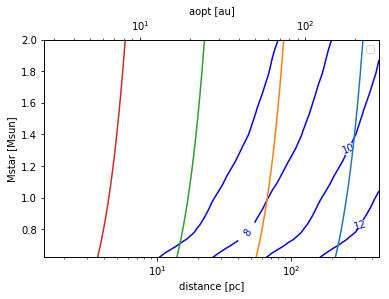

In [20]:
# plot contour map
# available lvls [ 0.  3.  6.  9. 12. 15. 18.]
fig, ax = plt.subplots()
CS2 = ax.contour(AOPTIMAG/(AU*0.7), MSIMAG/MSUN, IMAGREAL, levels=[6, 8, 10, 12], colors='b')
ax.clabel(CS2, inline=1, fontsize=10, fmt='%1i')
ax.set_xscale('log')
ax2 = ax.twiny()
for i in range(len(aopt_list)):
    ax2.plot(np.array(aopt_list[i])/AU, Ms/MSUN, label="M0: {0:.0e}".format(M0_list[i]/MEARTH))
if targetMIN is not None:
    ax.set_ylim([targetMIN, 2])
ax.set_ylabel('Mstar [Msun]')
ax.set_xlabel('distance [pc]')
ax2.set_xlabel('aopt [au]')
ax2.set_xscale('log')
ax.legend()

No handles with labels found to put in legend.


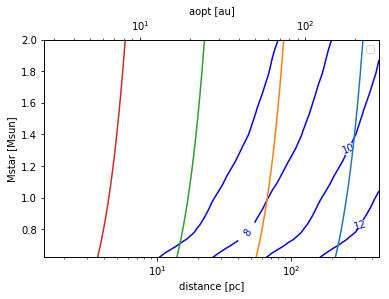

In [18]:
# plot contour map
fig, ax = plt.subplots()
CS2 = ax.contour(AOPTIMAG/(AU*0.7), MSIMAG/MSUN, IMAGREAL,levels=[6, 8, 10, 12], colors='b')
ax.clabel(CS2, inline=1, fontsize=10, fmt='%1i')
ax.set_xscale('log')

ax2 = ax.twiny()

for i in range(len(aopt2_list)):
    ax2.plot(np.array(aopt2_list[i])/AU, Ms/MSUN, label="M0: {0:.0e}".format(M0_list[i]/MEARTH))
if targetMIN is not None:
    ax.set_ylim([targetMIN, 2])
ax.set_ylabel('Mstar [Msun]')
ax2.set_xlabel('aopt [au]')
ax.set_xlabel('distance [pc]')
ax2.set_xscale('log')
ax.legend()

Text(0.5,0,'aopt [au]')

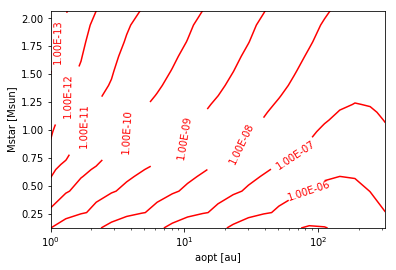

In [19]:
# plot contour map
from matplotlib import ticker, cm
fig, ax = plt.subplots()
CS = ax.contour(APL/AU, MS/MSUN, CRSCAT,locator=ticker.LogLocator(), colors='r')
ax.clabel(CS, inline=1, fontsize=10, fmt='%.2E')
ax.set_xscale('log')
ax.set_ylabel('Mstar [Msun]')
ax.set_xlabel('aopt [au]')